In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Your Turn!
Ok now that you are familiar with the synatx

# Data
We are using FashionMNIST data. The features (inputs) are black & white photos of clothes. The labels (outputs) are which type of clothing it is.

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(), 
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


def filter_classes(dataset, classes):
    """
    Filter dataset to only include specified classes.
    Relabels classes to 0, 1, 2, ... for the subset.
    """
    # Map old labels to new labels: {0: 0, 3: 1, 6: 2} for CLASSES=[0,3,6]
    label_map = {old: new for new, old in enumerate(classes)}
    
    # Find indices where label is in our class list
    mask = torch.tensor([label in classes for label in dataset.targets])
    indices = mask.nonzero(as_tuple=True)[0]
    
    # Create filtered dataset
    dataset.data = dataset.data[indices]
    dataset.targets = torch.tensor([label_map[t.item()] for t in dataset.targets[indices]])
    
    return dataset

CLASSES = list(range(10))
train_dataset = filter_classes(train_dataset, CLASSES)
test_dataset = filter_classes(test_dataset, CLASSES)

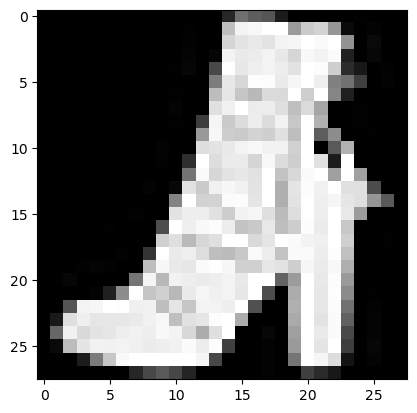

In [36]:
# Example of an image from the dataset
image_id = 11
plt.imshow(train_dataset[image_id][0].squeeze(), cmap='gray')

# MLP
You are NOT allowed to use convolutional layers in this exercise.

In [37]:
class MLP(nn.Module):
    """
    Multi-layer perceptron with configurable architecture.
    """
    
    def __init__(self, 
                 input_dim: int, 
                 hidden_layers: list, 
                 output_dim: int, 
                 activation: nn.Module):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(activation())
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        # No activation on output — CrossEntropyLoss expects raw logits
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # Flatten image: (batch, 1, 28, 28) -> (batch, 784)
        x = x.view(x.size(0), -1)
        return self.network(x)

# Model + Training

In [ ]:
HIDDEN_LAYERS = [32, 32]  # List of hidden layer sizes, e.g., [256, 128, 64]
ACTIVATION = nn.ReLU            # Try: nn.Tanh, nn.Sigmoid, nn.LeakyReLU, nn.GELU
LEARNING_RATE = 1e-2            # Try: 1e-1, 1e-3, 5e-4
BATCH_SIZE = 128                # Try: 64, 256   
EPOCHS = 10
# Are there other hyperparameters to consider?

model = MLP(
        input_dim=28*28, # Do not change, input is 28x28 images
        hidden_layers=HIDDEN_LAYERS,
        output_dim=len(CLASSES),
        activation=ACTIVATION,
    )

loss_fn = nn.CrossEntropyLoss() # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [40]:
model.train()  # Enable dropout, batch norm training mode, etc.
total_loss = 0.0

for epoch in range(EPOCHS):
    total_loss_train = 0.0
    for data, target in tqdm(train_loader):        
        # Forward pass
        output = model(data)
        loss = loss_fn(output, target)
        
        # Backward pass (compute gradients)
        optimizer.zero_grad()  # Clear gradients from previous step
        loss.backward()        # Backpropagation: ∂L/∂θ for all parameters
        optimizer.step()       # Update: θ → θ - η * ∂L/∂θ

        total_loss_train += loss.item()

    # Logging
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data_val, target_val in test_loader:
            output_val = model(data_val)
            total_loss += nn.CrossEntropyLoss()(output_val, target_val).item() * target_val.size(0)
            _, predicted = torch.max(output_val, 1)
            correct += (predicted == target_val).sum().item()
            total += target_val.size(0)

    avg_loss_train = total_loss_train / len(train_loader)

    val_loss = total_loss / total
    val_accuracy = 100.0 * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_loss_train:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

100%|██████████| 469/469 [00:12<00:00, 36.36it/s]


Epoch 1/10, Train Loss: 0.5156, Val Loss: 0.4381, Val Acc: 83.72%


100%|██████████| 469/469 [00:12<00:00, 39.04it/s]


Epoch 2/10, Train Loss: 0.3988, Val Loss: 0.4253, Val Acc: 84.73%


100%|██████████| 469/469 [00:10<00:00, 46.71it/s]


Epoch 3/10, Train Loss: 0.3577, Val Loss: 0.4593, Val Acc: 83.41%


 27%|██▋       | 128/469 [00:02<00:07, 47.82it/s]


KeyboardInterrupt: 